In [38]:
import numpy as np
from pathlib import Path
import skimage as sk
import cv2 as cv
import skimage.io as skio
import skimage.color as skcolor
import skimage.transform as sktr
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.signal as scsignal
import time

def load_image(path, greyscale=True):
    im = skio.imread(path)
    im = sk.img_as_float(im)
    
    # remove alpha if its there
    if im.shape[-1] == 4:
        im = skcolor.rgba2rgb(im)

    if greyscale and im.ndim == 3:
        im = skcolor.rgb2gray(im)
    return im

def save_image(path, im):
    skio.imsave(path, sk.img_as_ubyte(im))

def get_points(im1, im2=None):
    print('Please select 10 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = plt.ginput(10)
    plt.close()
    if im2 is None:
        return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
    plt.imshow(im2)
    p11, p12, p13, p14, p15, p16, p17, p18, p19, p20 = plt.ginput(10)
    plt.close()
    return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10], [p11, p12, p13, p14, p15, p16, p17, p18, p19, p20]

def get_4_points(im1):
    print('Please select 4 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2, p3, p4 = plt.ginput(4)
    plt.close()
    return [p1, p2, p3, p4]

# A.1: Shoot the Pictures

In [95]:
# Get Points
im1 = load_image('./images/set1/L1.jpg', greyscale=False)
im2 = load_image('./images/set1/L2.jpg', greyscale=False)

# downsize our images by 80%
h, w = im1.shape[:2]
im1 = sktr.resize(im1, (int(h * 0.20), int(w * 0.20)))
h, w = im2.shape[:2]
im2 = sktr.resize(im2, (int(h * 0.20), int(w * 0.20)))

%matplotlib qt
points1, points2 = get_points(im1, im2)
%matplotlib inline

Please select 10 points in each image for alignment.


# A.2: Recover Homographies

In [96]:
def computeH(im1_pts, im2_pts):
    A = []
    b = []
    for i in range(len(im1_pts)):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        A.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])

        b.append(x2)
        b.append(y2)
    
    A = np.array(A)
    b = np.array(b)
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(h, 1).reshape(3, 3)
    return H

# A.3: Warp the Images

In [97]:
def get_warped_corners(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1], [w-1, 0, 1], [w-1, h-1, 1], [0, h-1, 1]]).T
    
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]

    x_min, y_min = np.min(warped_corners[:2, :], axis=1)
    x_max, y_max = np.max(warped_corners[:2, :], axis=1)

    return x_min, y_min, x_max, y_max

def warpImageNearestNeighbor(im, H):
    h, w = im.shape[:2]
    x_min, y_min, x_max, y_max = get_warped_corners(im, H)
    
    out_w = int(np.ceil(x_max - x_min))
    out_h = int(np.ceil(y_max - y_min))
    output_shape = (out_h, out_w)

    output = np.zeros(output_shape + im.shape[2:], dtype=im.dtype)
    H_inv = np.linalg.inv(H)
    for i in range(out_h):
        for j in range(out_w):
            target_point_h = np.array([j + x_min, i + y_min, 1])
            src_point = H_inv @ target_point_h
            src_x_normalized = src_point[0] / src_point[2]
            src_y_normalize = src_point[1] / src_point[2]

            src_y_neighbor = np.round(src_y_normalize).astype(int)
            src_x_neighbor = np.round(src_x_normalized).astype(int)

            if 0 <= src_x_neighbor < w and 0 <= src_y_neighbor < h:
                output[i, j] = im[src_y_neighbor, src_x_neighbor]
    return output

def warpImageBilinear(im, H):
    h, w = im.shape[:2]
    x_min, y_min, x_max, y_max = get_warped_corners(im, H)

    out_w = int(np.ceil(x_max - x_min))
    out_h = int(np.ceil(y_max - y_min))
    output_shape = (out_h, out_w)

    output = np.zeros(output_shape + im.shape[2:], dtype=im.dtype)
    H_inv = np.linalg.inv(H)

    for i in range(out_h):
        for j in range(out_w):
            target_point_h = np.array([j + x_min, i + y_min, 1])
            src_point_h = H_inv @ target_point_h
            
            src_x = src_point_h[0] / src_point_h[2] 
            src_y = src_point_h[1] / src_point_h[2] 

            x0 = int(np.floor(src_x))
            y0 = int(np.floor(src_y))
            x1 = x0 + 1
            y1 = y0 + 1
            
            if not (0 <= x0 and x1 < w and 0 <= y0 and y1 < h):
                continue

            dx = src_x - x0
            dy = src_y - y0
            
            interpolated_pixel = np.zeros(im.shape[2], dtype=im.dtype)
            for channel in range(im.shape[2]):
                top_left = im[y0, x0, channel]
                top_right = im[y0, x1, channel]
                bottom_left = im[y1, x0, channel]
                bottom_right = im[y1, x1, channel]
                top_interp = top_left * (1 - dx) + top_right * dx
                bottom_interp = bottom_left * (1 - dx) + bottom_right * dx
                interpolated_val = top_interp * (1 - dy) + bottom_interp * dy
                interpolated_pixel[channel] = interpolated_val
            
            output[i, j] = interpolated_pixel
            
    return output


In [135]:
to_rectify = load_image('./images/rectify/square2.jpg', greyscale=False)
h, w = to_rectify.shape[:2]

to_rectify = sktr.resize(to_rectify, (int(h * 0.2), int(w * 0.2)))

%matplotlib qt
rectify_points = get_4_points(to_rectify)
%matplotlib inline

points = np.array(rectify_points)
target_width = 200
target_height = 150 

# Define the corners of your target square
points_dst = np.array([
    [0, 0],
    [target_width - 1, 0],
    [target_width - 1, target_height - 1],
    [0, target_height - 1]
])

H_rectify = computeH(rectify_points, points_dst)
bil_start = time.perf_counter()
rectified_bilinear = warpImageBilinear(to_rectify, H_rectify)
bil_end= time.perf_counter()

neighbor_start = time.perf_counter()
rectified_neighbor = warpImageNearestNeighbor(to_rectify, H_rectify)
neighbor_end= time.perf_counter()
n_time = neighbor_end - neighbor_start
b_time = bil_end - bil_start
print(f"Nearest Neighbor Time: {n_time:.4f}")
print(f"Bilinear Time: {b_time:.4f}")
save_image('./images/rectify/square2_rectified_neighbor.jpg', rectified_neighbor)
save_image('./images/rectify/square2_rectified_bilinear.jpg', rectified_bilinear)

Please select 4 points in each image for alignment.
Nearest Neighbor Time: 6.5984
Bilinear Time: 5.9897


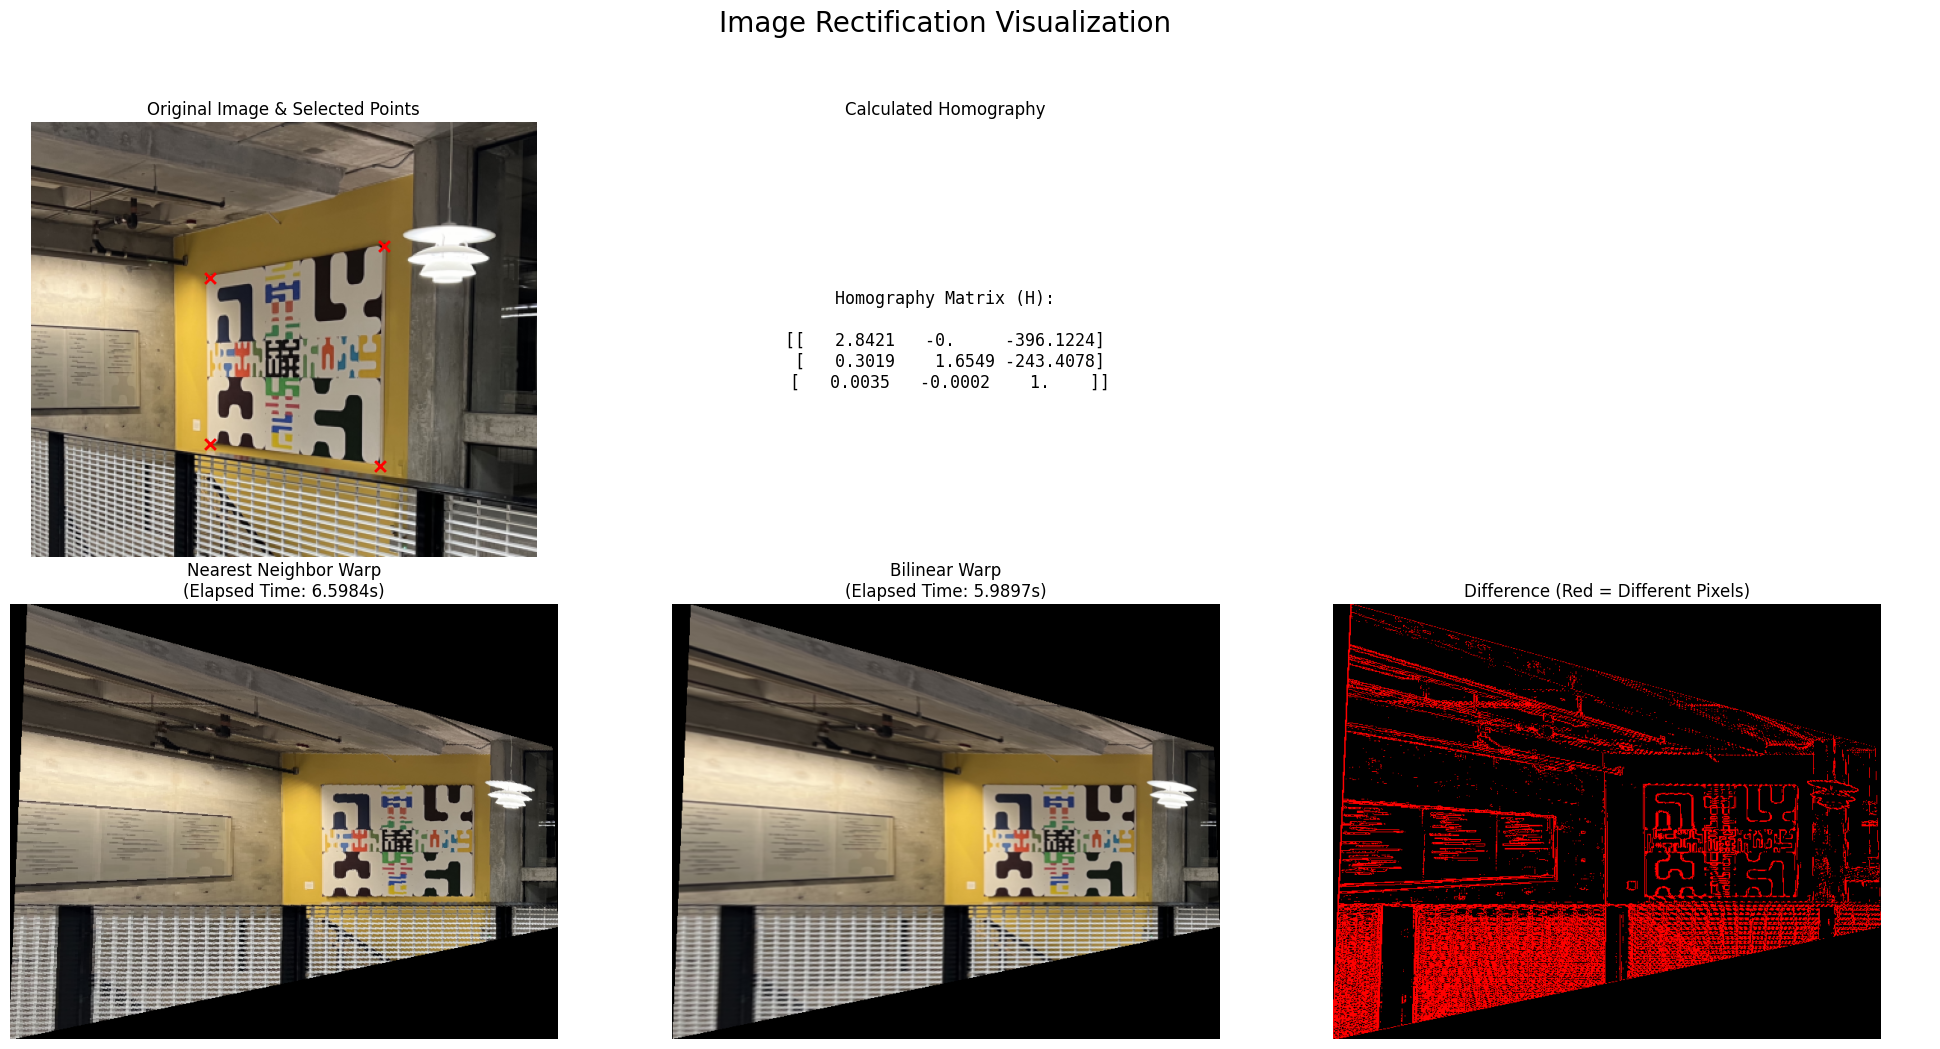

In [136]:
h_b, w_b = rectified_bilinear.shape[:2]
diff = np.abs(rectified_neighbor.astype(float) - rectified_bilinear.astype(float))
diff_mask = np.sum(diff, axis=2) > 0.05
diff_viz = np.zeros_like(rectified_bilinear)
diff_viz[diff_mask] = [1, 0, 0] # Red

fig, axs = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('Image Rectification Visualization', fontsize=20)

axs[0, 0].imshow(to_rectify)
axs[0, 0].scatter(points[:, 0], points[:, 1], c='red', s=60, marker='x', linewidths=2)
axs[0, 0].set_title('Original Image & Selected Points')
axs[0, 0].axis('off')

axs[0, 1].axis('off')
h_text = "Homography Matrix (H):\n\n" + np.array2string(H_rectify, precision=4, suppress_small=True)
axs[0, 1].text(0.5, 0.5, h_text, ha='center', va='center', fontsize=12, fontfamily='monospace')
axs[0, 1].set_title('Calculated Homography')

axs[0, 2].axis('off')

axs[1, 0].imshow(rectified_neighbor)
axs[1, 0].set_title(f'Nearest Neighbor Warp\n(Elapsed Time: {n_time:.4f}s)')
axs[1, 0].axis('off')

axs[1, 1].imshow(rectified_bilinear)
axs[1, 1].set_title(f'Bilinear Warp\n(Elapsed Time: {b_time:.4f}s)')
axs[1, 1].axis('off')

axs[1, 2].imshow(diff_viz)
axs[1, 2].set_title('Difference (Red = Different Pixels)')
axs[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./images/rectify/square2_rectification_visualization.jpg")
plt.show()

# A.4

In [72]:
def plot_correspondences(im1, im2, points1, points2):
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]

    total_width = w1 + w2
    sidebyside = np.zeros((h1, total_width, 3), dtype=im1.dtype)
    sidebyside[:h1, :w1, :] = im1
    sidebyside[:h2, w1:w1+w2, :] = im2
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(sidebyside)
    
    num_points = len(points1)
    cmap = plt.get_cmap('gist_rainbow', num_points)

    for i in range(num_points):
        x1, y1 = points1[i]
        x2, y2 = points2[i]

        x2_offset = x2 + w1
        color = cmap(i)

        ax.scatter(x1, y1, s=100, facecolors='none', edgecolors=color, marker='o', linewidth=2)
        ax.scatter(x2_offset, y2, s=100, facecolors='none', edgecolors=color, marker='o', linewidth=2)
        ax.plot([x1, x2_offset], [y1, y2], color=color, linestyle='-', linewidth=1.5)

    ax.axis('off')
    plt.tight_layout()
    plt.savefig("./images/set3/point_correspondences.jpg")
    plt.show()


[[ 1.98103432e+00 -2.55811245e-02 -7.39673024e+02]
 [ 3.62152215e-01  1.70338634e+00 -1.67891490e+02]
 [ 1.20472632e-03  3.21728416e-05  1.00000000e+00]]


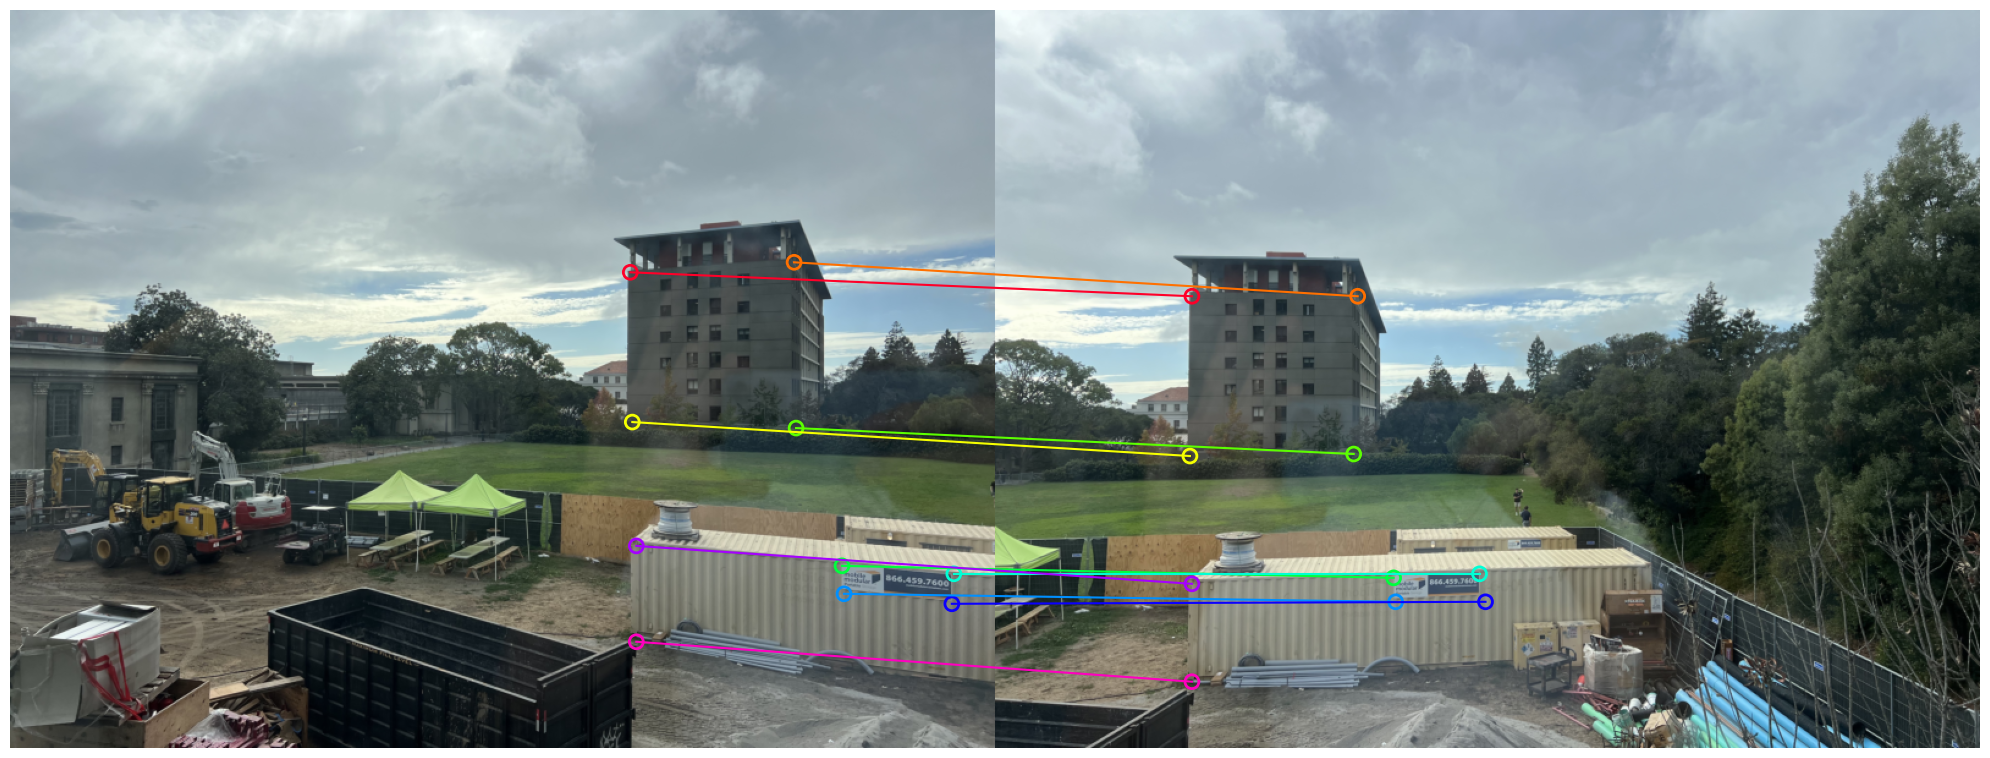

In [98]:

H = computeH(points1, points2)
print(H)

plot_correspondences(im1, im2, points1, points2)

In [99]:
def make_gaussian(sigma):
    size = int(6 * sigma)
    if size % 2 == 0: size += 1
    g_1d = cv.getGaussianKernel(size, sigma)
    gaussian = np.outer(g_1d, g_1d.transpose())
    return gaussian

def pyramids(image, sigma, num_levels, color=False, stack=True):
    gaussian_pyr = [image.copy()]
    current_image = image.copy()
    for _ in range(num_levels):
        kernel = make_gaussian(sigma)
        if color:
            blurred_channels = []
            for i in range(current_image.shape[2]):
                channel = current_image[:, :, i]
                blurred_channel = scsignal.convolve2d(channel, kernel, mode='same', boundary='symm')
                blurred_channels.append(blurred_channel)
            blurred = np.stack(blurred_channels, axis=2)
        else:
            blurred = scsignal.convolve2d(current_image, kernel, mode='same', boundary='symm')

        if not stack:
            channel_axis = 2 if color else None
            downsampled = sktr.rescale(blurred, 0.5, anti_aliasing=True, channel_axis=channel_axis)
            gaussian_pyr.append(downsampled)
            current_image = downsampled
        else:
            gaussian_pyr.append(blurred)
            current_image = blurred
            sigma *= 2

    
    laplacian_pyr = []
    for i in range(num_levels):
        target_shape = gaussian_pyr[i].shape
        upsampled = sktr.resize(gaussian_pyr[i+1], target_shape, anti_aliasing=True)

        laplacian_level = gaussian_pyr[i] - upsampled
        laplacian_pyr.append(laplacian_level)

    laplacian_pyr.append(gaussian_pyr[-1])

    return laplacian_pyr, gaussian_pyr

def blend_pyramids(pyramidA, pyramidB, pyramidM):
    blended_pyramid = []
    for LA, LB, GR in zip(pyramidA, pyramidB, pyramidM):
        # LS = GR * LA + (1 - GR) * LB
        blended_level = GR * LA + (1.0 - GR) * LB
        blended_pyramid.append(blended_level)

    return blended_pyramid

def collapse_pyramid(pyramid):
    final_image = pyramid[-1]
    # start from second to last before cork up to first
    for i in range(len(pyramid) - 2, -1, -1):
        target_shape = pyramid[i].shape
        upsampled = sktr.resize(final_image, target_shape, anti_aliasing=True)
        final_image = upsampled + pyramid[i]
    return np.clip(final_image, 0, 1)

In [94]:
from scipy.ndimage import distance_transform_edt
from skimage.util import img_as_float

def get_mosaic_canvas_size(images, homographies):
    all_corners = []
    for i, im in enumerate(images):
        h, w = im.shape[:2]
        corners = np.array([[0, w-1, w-1, 0], [0, 0, h-1, h-1], [1, 1, 1, 1]])
        warped_corners = homographies[i] @ corners
        warped_corners /= warped_corners[2, :]
        all_corners.append(warped_corners[:2, :])

    all_corners = np.hstack(all_corners)
    x_min, y_min = np.min(all_corners, axis=1)
    x_max, y_max = np.max(all_corners, axis=1)
    canvas_shape = (int(np.ceil(y_max - y_min)), int(np.ceil(x_max - x_min)))
    return canvas_shape, (x_min, y_min)

def create_mosaic_no_blend(images, homographies, warp_func):
    canvas_shape, (canvas_x_min, canvas_y_min) = get_mosaic_canvas_size(images, homographies)
    mosaic = np.zeros(canvas_shape + (images[0].shape[2],), dtype=images[0].dtype)

    for i, im in enumerate(images):
        H = homographies[i]

        warped_im = warp_func(im, H)
        h_im, w_im = warped_im.shape[:2]

        im_x_min, im_y_min, _, _ = get_warped_corners(im, H)

        # shift negative coords of warped image to be at top left corner
        y_start = int(round(im_y_min - canvas_y_min))
        x_start = int(round(im_x_min - canvas_x_min))
        
        # bottom right
        y_end = y_start + h_im
        x_end = x_start + w_im
        
        if y_end > mosaic.shape[0] or x_end > mosaic.shape[1] or y_start < 0 or x_start < 0:
            continue

        mask = warped_im.any(axis=2)
        image_mosaic_bounds = mosaic[y_start:y_end, x_start:x_end]
        image_mosaic_bounds[mask] = warped_im[mask]
    
    return mosaic

def create_optimal_mask(imageA, imageB, blur_sigma=15):
    black_A = imageA.any(axis=2) # get where we have black
    black_B = imageB.any(axis=2)
    distA = distance_transform_edt(black_A) # get distances
    distB = distance_transform_edt(black_B)
    mask = np.where(distA > distB, 1.0, 0.0) # make a binary mask
    mask[~black_B] = 1.0
    mask[~black_A] = 0.0
    return np.stack([mask] * 3, axis=-1)

def two_band_blend(image1, image2, hard_mask):
    sigma = 10
    gaussian = make_gaussian(sigma)

    smooth_mask = np.zeros_like(hard_mask)
    for i in range(image1.shape[2]):
        smooth_mask[:,:,i] = scsignal.convolve2d(hard_mask[:,:,i], gaussian, mode='same', boundary='symm')
    
    low1 = np.zeros_like(image1)
    low2 = np.zeros_like(image2)
    
    for i in range(image1.shape[2]):
        low1[:, :, i] = scsignal.convolve2d(image1[:, :, i], gaussian, mode='same', boundary='symm')
        low2[:, :, i] = scsignal.convolve2d(image2[:, :, i], gaussian, mode='same', boundary='symm')

    high1 = image1 - low1
    high2 = image2 - low2

    blended_low = smooth_mask * low1 + (1.0 - smooth_mask) * low2
    blended_high = hard_mask * high1 + (1.0 - hard_mask) * high2

    final_image = blended_low + blended_high
    
    return np.clip(final_image, 0, 1)

def create_blended_mosaic(images, homographies, warp_func):
    canvas_shape, (canvas_x_min, canvas_y_min) = get_mosaic_canvas_size(images, homographies)
    canvases = []
    
    for i, im in enumerate(images):
        H = homographies[i]

        warped_im = warp_func(im, H)
        h_im, w_im = warped_im.shape[:2]

        im_x_min, im_y_min, _, _ = get_warped_corners(im, H)
        y_start = int(round(im_y_min - canvas_y_min))
        x_start = int(round(im_x_min - canvas_x_min))
        y_end = y_start + h_im
        x_end = x_start + w_im
        
        im_canvas = np.zeros(canvas_shape + (im.shape[2],), dtype=np.float32)

        dest_y_start = max(0, y_start)
        dest_y_end = min(canvas_shape[0], y_end)
        dest_x_start = max(0, x_start)
        dest_x_end = min(canvas_shape[1], x_end)
        
        src_y_start = dest_y_start - y_start
        src_y_end = dest_y_end - y_start
        src_x_start = dest_x_start - x_start
        src_x_end = dest_x_end - x_start
        
        if dest_y_end > dest_y_start and dest_x_end > dest_x_start:
            image_layer_bounds = im_canvas[dest_y_start:dest_y_end, dest_x_start:dest_x_end]
            image_layer_bounds[:,:] = img_as_float(warped_im[src_y_start:src_y_end, src_x_start:src_x_end])

        canvases.append(im_canvas)

    image1, image2 = canvases[0], canvases[1]

    hard_mask = create_optimal_mask(image1, image2)
    blended_image = two_band_blend(image1, image2, hard_mask)
    
    return (blended_image * 255).astype(np.uint8)

In [ ]:
H_ref = np.eye(3)
    
images = [im2, im1]
homographies = [H_ref, H]

mosaic_image_neighbor = create_blended_mosaic(images, homographies, warpImageNearestNeighbor)
mosaic_image_bilinear = create_blended_mosaic(images, homographies, warpImageBilinear)
non_blend = create_mosaic_no_blend(images, homographies, warpImageBilinear)

save_image("./images/set3/mosaic_image_neighbor.png", mosaic_image_neighbor)
save_image("./images/set3/mosaic_image_bilinear.png", mosaic_image_bilinear)
save_image("./images/set1/example_nonblend_bilinear.png", non_blend)

# B.1

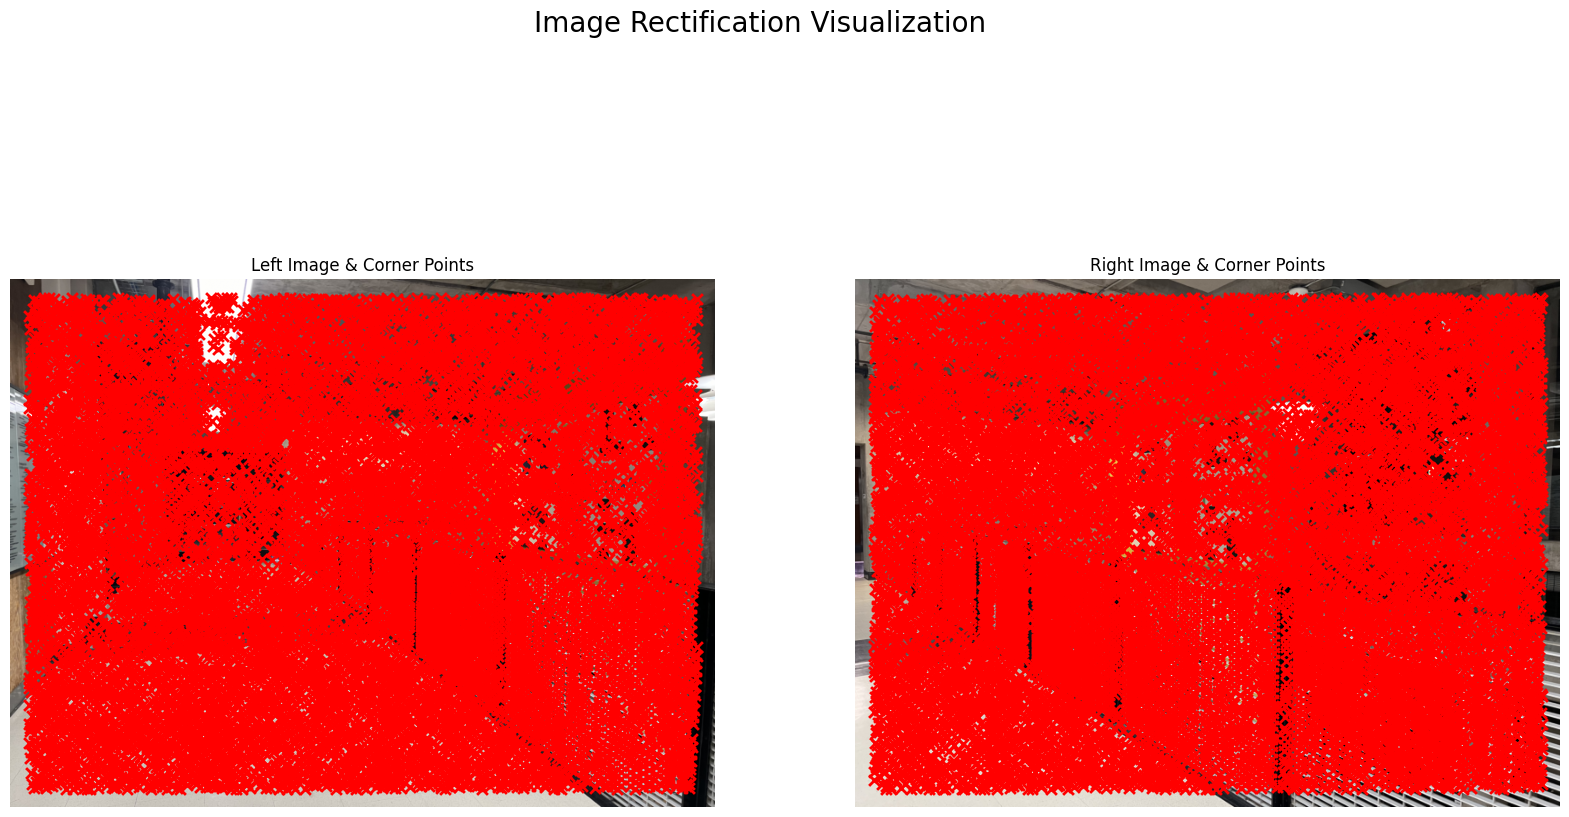

In [134]:
from harris import get_harris_corners, dist2

image1 = load_image('./images/set3/L1.jpg', greyscale=False)
image2 = load_image('./images/set3/L2.jpg', greyscale=False)

# downsize our images by 80%
image1_gray = skcolor.rgb2gray(image1)
image2_gray = skcolor.rgb2gray(image2)

h, w = image1_gray.shape[:2]
image1_resized = sktr.resize(image1_gray, (int(h * 0.20), int(w * 0.20)))
h, w = image2_gray.shape[:2]
image2_resized = sktr.resize(image2_gray, (int(h * 0.20), int(w * 0.20)))

h1, corners_1 = get_harris_corners(image1_resized)
h2, corners_2 = get_harris_corners(image2_resized)

fig, axs = plt.subplots(1, 2, figsize=(20, 11))
fig.suptitle('Image Rectification Visualization', fontsize=20)

h_orig, w_orig = image1.shape[:2]
image1_display = sktr.resize(image1, (int(h_orig * 0.20), int(w_orig * 0.20)))

h_orig, w_orig = image2.shape[:2]
image2_display = sktr.resize(image2, (int(h_orig * 0.20), int(w_orig * 0.20)))


axs[0].imshow(image1_display)
axs[0].scatter(corners_1[1, :], corners_1[0, :], c='red', s=60, marker='x', linewidths=2)
axs[0].set_title('Left Image & Corner Points')
axs[0].axis('off')

axs[1].imshow(image2_display)
axs[1].scatter(corners_2[1, :], corners_2[0, :], c='red', s=60, marker='x', linewidths=2)
axs[1].set_title('Right Image & Corner Points')
axs[1].axis('off')

plt.show()

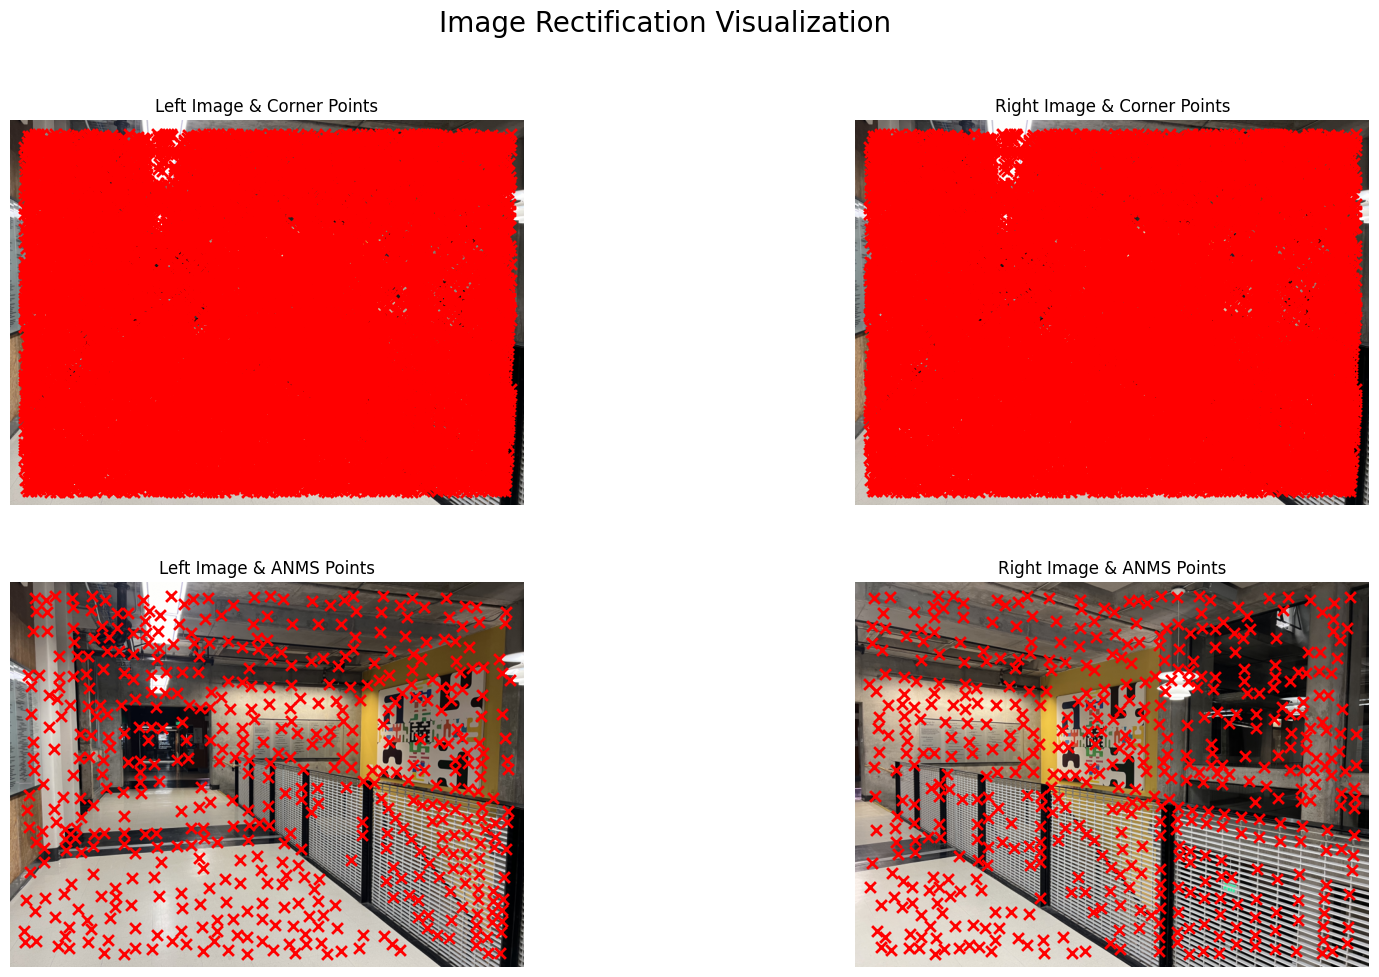

In [135]:
def anms(points, h, num_points=500):
    strengths = h[points[0, :], points[1, :]]

    sorted_indices = np.argsort(strengths)[::-1]
    sorted_points = points[:, sorted_indices]
    
    num_corners = points.shape[1]
    
    radii = np.full(num_corners, float('inf'))

    for i in range(1, num_corners):
        stronger_points = sorted_points[:, :i]
        
        diff = stronger_points - sorted_points[:, i].reshape(2, 1)
        dist_sq = np.sum(diff**2, axis=0)
        
        radii[i] = np.min(dist_sq)
        
    best_indices = np.argsort(radii)[::-1][:num_points]

    final_corners = sorted_points[:, best_indices]

    return final_corners
                
anms_corners_1 = anms(corners_1, h1)
anms_corners_2 = anms(corners_2, h2)

fig, axs = plt.subplots(2, 2, figsize=(20, 11))
fig.suptitle('Image Rectification Visualization', fontsize=20)

h_orig, w_orig = image1.shape[:2]
image1_display = sktr.resize(image1, (int(h_orig * 0.20), int(w_orig * 0.20)))

h_orig, w_orig = image2.shape[:2]
image2_display = sktr.resize(image2, (int(h_orig * 0.20), int(w_orig * 0.20)))

axs[0, 0].imshow(image1_display)
axs[0, 0].scatter(corners_1[1, :], corners_1[0, :], c='red', s=60, marker='x', linewidths=2)
axs[0, 0].set_title('Left Image & Corner Points')
axs[0, 0].axis('off')

axs[1, 0].imshow(image1_display)
axs[1, 0].scatter(anms_corners_1[1, :], anms_corners_1[0, :], c='red', s=60, marker='x', linewidths=2)
axs[1, 0].set_title('Left Image & ANMS Points')
axs[1, 0].axis('off')

axs[0, 1].imshow(image1_display)
axs[0, 1].scatter(corners_1[1, :], corners_1[0, :], c='red', s=60, marker='x', linewidths=2)
axs[0, 1].set_title('Right Image & Corner Points')
axs[0, 1].axis('off')

axs[1, 1].imshow(image2_display)
axs[1, 1].scatter(anms_corners_2[1, :], anms_corners_2[0, :], c='red', s=60, marker='x', linewidths=2)
axs[1, 1].set_title('Right Image & ANMS Points')
axs[1, 1].axis('off')

plt.show()

# B.2

In [136]:
def normalize_patch(patch):
    mean = np.mean(patch)
    std_dev = np.std(patch)

    return (patch - mean) / std_dev

def feature_extraction(im, points):
    patches = []
    gaussian = make_gaussian(5)
    for i in range(len(points[0])):
        y = points[0][i]
        x = points[1][i]
        patch = im[y-20:y+20, x-20:x+20]
        blurred = scsignal.convolve2d(patch, gaussian, mode='same', boundary='symm')
        downsized_8x8 = sktr.resize(blurred, (8, 8))
        normalized = normalize_patch(downsized_8x8)
        patches.append(normalized)

    return patches

patches_1 = feature_extraction(image1_resized, anms_corners_1)
patches_2 = feature_extraction(image2_resized, anms_corners_2)

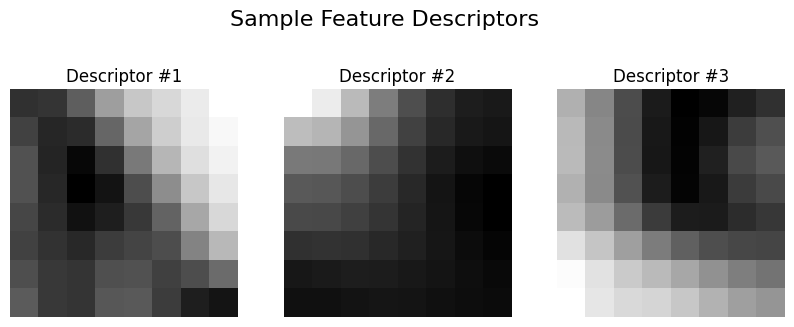

In [137]:
patches_1 = np.array(patches_1)

num_patches = len(patches_1)
sample_idx = np.random.choice(num_patches, size=3, replace=False)
sample_patches = patches_1[sample_idx]

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Sample Feature Descriptors', fontsize=16)

for i in range(3):
    vis_patch = sample_patches[i]
    if vis_patch.max() > vis_patch.min():
        vis_patch = (vis_patch - vis_patch.min()) / (vis_patch.max() - vis_patch.min())
    
    axs[i].imshow(vis_patch, cmap='gray')
    axs[i].set_title(f'Descriptor #{i+1}')
    axs[i].axis('off')

plt.show()

# B.3

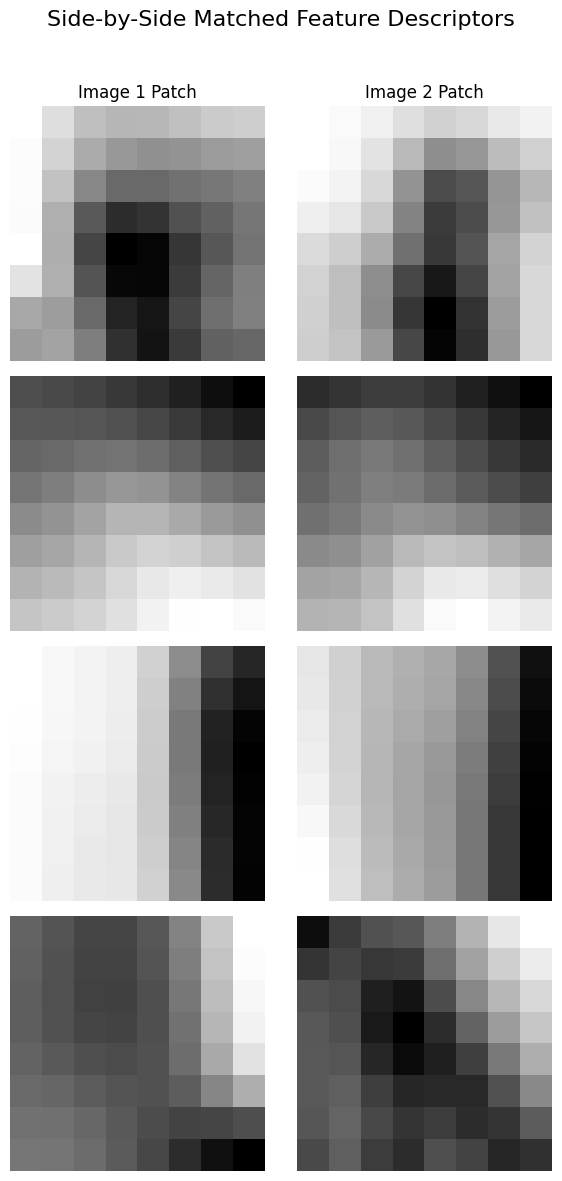

In [138]:
def correspondence_finder(p1, p2, threshold=.90):
    correspondence_list = []

    for patch1 in p1:
        d1 = np.inf
        d2 = np.inf
        d1_patch = None
        d2_patch = None

        for patch2 in p2:
            dist = dist2(patch1, patch2)
            if dist < d1:
                d1 = dist
                d1_patch = patch2
            elif dist < d2:
                d2 = dist
                d2_patch = patch2

        ratio = d1 / d2
        if ratio < threshold:
            correspondence_list.append((patch1, d1_patch))

    return correspondence_list

def correspondence_list(p1, p2, threshold=.90):
    p1 = np.array(patches_1)
    p2 = np.array(patches_2)
    p1 = p1.reshape(p1.shape[0], -1)
    p2 = p2.reshape(p2.shape[0], -1)

    dist_matrix = dist2(p1, p2)
    indices = np.argsort(dist_matrix, axis=1)[:, :2]

    d1 = np.take_along_axis(dist_matrix, indices[:, 0:1], axis=1).flatten()
    d2 = np.take_along_axis(dist_matrix, indices[:, 1:2], axis=1).flatten()

    match_indices_p1 = np.where(d1 < threshold * d2)[0]
    
    match_indices_p2 = indices[match_indices_p1, 0]

    correspondence_list = list(zip(match_indices_p1, match_indices_p2))
    
    return correspondence_list
        
lister = correspondence_list(patches_1, patches_2)


num_matches_to_draw = 4
sample_indices = np.random.choice(len(lister), size=num_matches_to_draw, replace=False)
sample_matches = [lister[i] for i in sample_indices]

fig, axs = plt.subplots(num_matches_to_draw, 2, figsize=(6, 12))
fig.suptitle('Side-by-Side Matched Feature Descriptors', fontsize=16)

axs[0, 0].set_title('Image 1 Patch')
axs[0, 1].set_title('Image 2 Patch')

for i, (idx1, idx2) in enumerate(sample_matches):
    patch1 = patches_1[idx1]
    patch2 = patches_2[idx2]

    if patch1.max() > patch1.min():
        vis_patch1 = (patch1 - patch1.min()) / (patch1.max() - patch1.min())
    else:
        vis_patch1 = patch1
        
    if patch2.max() > patch2.min():
        vis_patch2 = (patch2 - patch2.min()) / (patch2.max() - patch2.min())
    else:
        vis_patch2 = patch2

    axs[i, 0].imshow(vis_patch1, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_ylabel(f'Match {i+1}', rotation=0, size='large', labelpad=30)

    axs[i, 1].imshow(vis_patch2, cmap='gray')
    axs[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# B.4

In [139]:
def count_inliers(H, correspondences, points1, points2, thresh):
    inliers = []

    sq_threshold = thresh**2

    for idx1, idx2 in correspondences:
        y1, x1 = points1[:, idx1]
        y2, x2 = points2[:, idx2]

        p1_homogeneous = np.array([x1, y1, 1])
        p1_transformed = H @ p1_homogeneous

        x_normalized = p1_transformed[0] / p1_transformed[2]
        y_normalized = p1_transformed[1] / p1_transformed[2]

        dist_sq = (x_normalized - x2)**2 + (y_normalized - y2)**2

        if dist_sq < sq_threshold:
            inliers.append((idx1, idx2))

    return len(inliers), inliers


def randomly_sample_4_correspondences(corresp):
    num_matches_to_draw = 4
    sample_indices = np.random.choice(len(corresp), size=num_matches_to_draw, replace=False)
    sample_matches = [corresp[i] for i in sample_indices]
    return sample_matches

def computeH(sample, points1, points2):
    """H from a correspondence list and not just points."""
    A = []
    b = []
    
    for idx1, idx2 in sample:
        y1, x1 = points1[:, idx1]
        y2, x2 = points2[:, idx2]
        
        A.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        A.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b.append(x2)
        b.append(y2)
    
    A = np.array(A)
    b = np.array(b)
    
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(h, 1).reshape(3, 3)
    return H


def RANSAC(correspondences, corners_1, corners_2, N=5000, threshold=5):
    best_H = None
    best_inlier_count = 0
    best_inliers = []
    for _ in range(N):
        sample = randomly_sample_4_correspondences(correspondences)
        H = computeH(sample, corners_1, corners_2)

        if H is None:
            continue

        inlier_count, inliers = count_inliers(H, correspondences, corners_1, corners_2, threshold)
        
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_H = H
            best_inliers = inliers

    print(f"RANSAC found a best model with {best_inlier_count} inliers.")
    
    if best_inlier_count > 4:
        final_H = computeH(best_inliers, corners_1, corners_2)
    else:
        final_H = best_H

    return final_H, best_inliers


print(len(lister))

H_auto, inlier_idxs = RANSAC(lister, anms_corners_1, anms_corners_2)

print(H_auto)


343
RANSAC found a best model with 85 inliers.
[[ 1.91715240e+00  1.02046266e-02 -5.91280547e+02]
 [ 3.12265846e-01  1.58475255e+00 -1.55049720e+02]
 [ 1.14359530e-03 -7.37138250e-05  1.00000000e+00]]


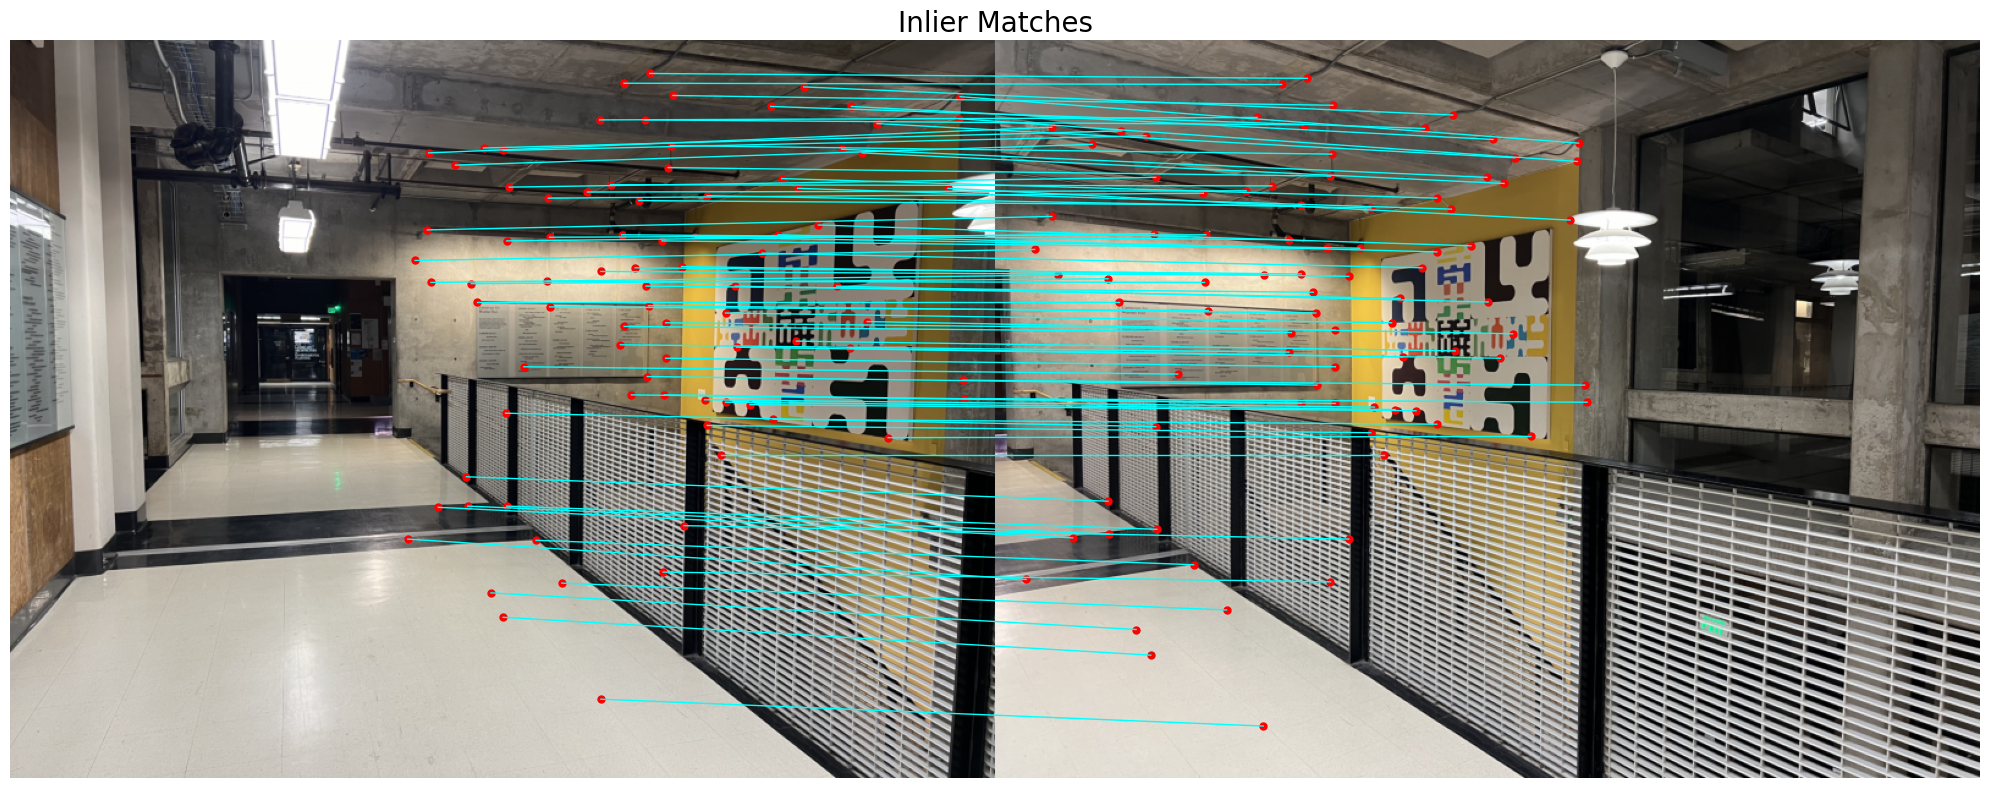

In [140]:
def plot_inlier_matches(im1, im2, all_coords1, all_coords2, match_indices, title='Inlier Matches'):
    h1, w1, _ = im1.shape
    combined_image = np.hstack((im1, im2))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(combined_image)
    ax.set_title(title, fontsize=20)
    ax.axis('off')

    for idx1, idx2 in match_indices:
        y1, x1 = all_coords1[:, idx1]
        y2, x2 = all_coords2[:, idx2]
        
        color = 'cyan'
        ax.plot([x1, x2 + w1], [y1, y2], color=color, linestyle='-', linewidth=1)
        ax.scatter([x1, x2 + w1], [y1, y2], c='red', s=25)

    plt.tight_layout()
    plt.show()

plot_inlier_matches(
    image1_display,
    image2_display,
    anms_corners_1,
    anms_corners_2,
    inlier_idxs
)

In [142]:
images_to_stitch = [image2_display, image1_display]

homographies_to_stitch = [np.eye(3), H_auto]

auto_blended_bilinear = create_blended_mosaic(images_to_stitch, homographies_to_stitch, warpImageBilinear)
auto_blended_neighbor = create_blended_mosaic(images_to_stitch, homographies_to_stitch, warpImageNearestNeighbor)
auto_non_blend = create_mosaic_no_blend(images_to_stitch, homographies_to_stitch, warpImageNearestNeighbor)


save_image("./images/set3/auto/mosaic_bilinear_auto.png", auto_blended_bilinear)
save_image("./images/set3/auto/mosaic_neighbor_auto.png", auto_blended_neighbor)
save_image("./images/set3/auto/no_blend_bilinear_auto.png", auto_non_blend)

print("Done")

Done
